## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

## Dataset

In [2]:
reviews = pd.read_csv("Restaurant_Reviews.tsv", sep="\t")

In [3]:
reviews.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
Review    1000 non-null object
Liked     1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


## Cleaning dataset

+ Testing in just one review

In [5]:
review = re.sub(r"[^a-zA-Z0-9]", " ", reviews["Review"][0])
review

'Wow    Loved this place '

In [6]:
tokens = [token.lower() for token in review.lower().split() if token not in set(stopwords.words("english"))]
tokens

['wow', 'loved', 'place']

In [7]:
stemmer = PorterStemmer()
stems = [stemmer.stem(token) for token in tokens]
stems

['wow', 'love', 'place']

In [8]:
review = " ".join(stems)
review

'wow love place'

+ Applying to whole dataset

In [9]:
stemmer = PorterStemmer()
def cleaning_text(review):
    cleaned = re.sub(r"[^a-zA-Z0-9]", " ", review)
    tokens = [token.lower() for token in cleaned.lower().split() if token not in set(stopwords.words("english"))]
    stems = [stemmer.stem(token) for token in tokens]
    return " ".join(stems)

In [10]:
reviews["Review"] = reviews["Review"].apply(cleaning_text)
reviews.head()

,Review,Liked
0,wow love place,1
1,crust good,0
2,tasti textur nasti,0
3,stop late may bank holiday rick steve recommen...,1
4,select menu great price,1


## Creating Model

In [11]:
reviews = pd.read_csv("Restaurant_Reviews.tsv", sep="\t")
X = reviews.iloc[:, 0]
y = reviews.iloc[:, -1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
class ReviewsCleaner(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer, stopwords):
        self.__stemmer = stemmer
        self.__stopwords = stopwords
        
    def fit(self, reviews, label=None):
        return self
    
    def __cleaning_text(self, review):
        cleaned = re.sub(r"[^a-zA-Z0-9]", " ", review).lower()
        tokens = [token.lower() for token in cleaned.split() if token not in set(self.__stopwords.words("english"))]
        stems = [self.__stemmer.stem(token) for token in tokens]
        return " ".join(stems)
    
    def transform(self, reviews):
        assert isinstance(reviews, pd.Series), "ERROR: Insert a pandas Series"
        return reviews.apply(self.__cleaning_text)

In [14]:
stemmer = PorterStemmer()

model = Pipeline(steps=[
    ("cleaning_texts", ReviewsCleaner(stemmer, stopwords)),
    ("bow", CountVectorizer(max_features=1500)),
    ("svm", SVC(C=1.0, kernel="linear", probability=True))
])

In [15]:
model.fit(X_train, y_train)

/Users/gfluz94/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(memory=None,
         steps=[('cleaning_texts',
                 ReviewsCleaner(stemmer=None, stopwords=None)),
                ('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=1500, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_it

In [16]:
y_pred = model.predict(X_test)
probas = model.predict_proba(X_test)

+ Metrics

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.75      0.73        97
           1       0.75      0.70      0.72       103

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.72       200
weighted avg       0.73      0.72      0.72       200



+ Confusion Matrix

In [18]:
def confusion_matrix(y_true, y_pred):    
    matrix = pd.DataFrame(data=y_true, index=y_true.index)
    matrix.rename(columns={"Liked": "Real"}, inplace=True)
    matrix["Predicted"] = y_pred
    matrix["Predicted"] = matrix["Predicted"].apply(lambda x: "Positive" if x==1 else "Negative")
    matrix["Real"] = matrix["Real"].apply(lambda x: "Positive" if x==1 else "Negative")
    return matrix.groupby(by=["Real", "Predicted"]).size().unstack()

In [19]:
confusion_matrix(y_test, y_pred)

Predicted,Negative,Positive
Real,,
Negative,73,24
Positive,31,72


+ ROC Curve and AUC

In [20]:
def plot_roc(y_true, probabilities):
    fpr, tpr, thresholds = roc_curve(y_true, probabilities[:,1])
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(fpr, tpr, color="green", label=f"SVM (AUC = {roc_auc_score(y_true, probabilities[:,1]):.3f})")
    plt.plot([0,1], [0,1], color="navy")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim((0,1))
    plt.ylim((0,1.001))
    plt.legend(loc=4)
    plt.show()

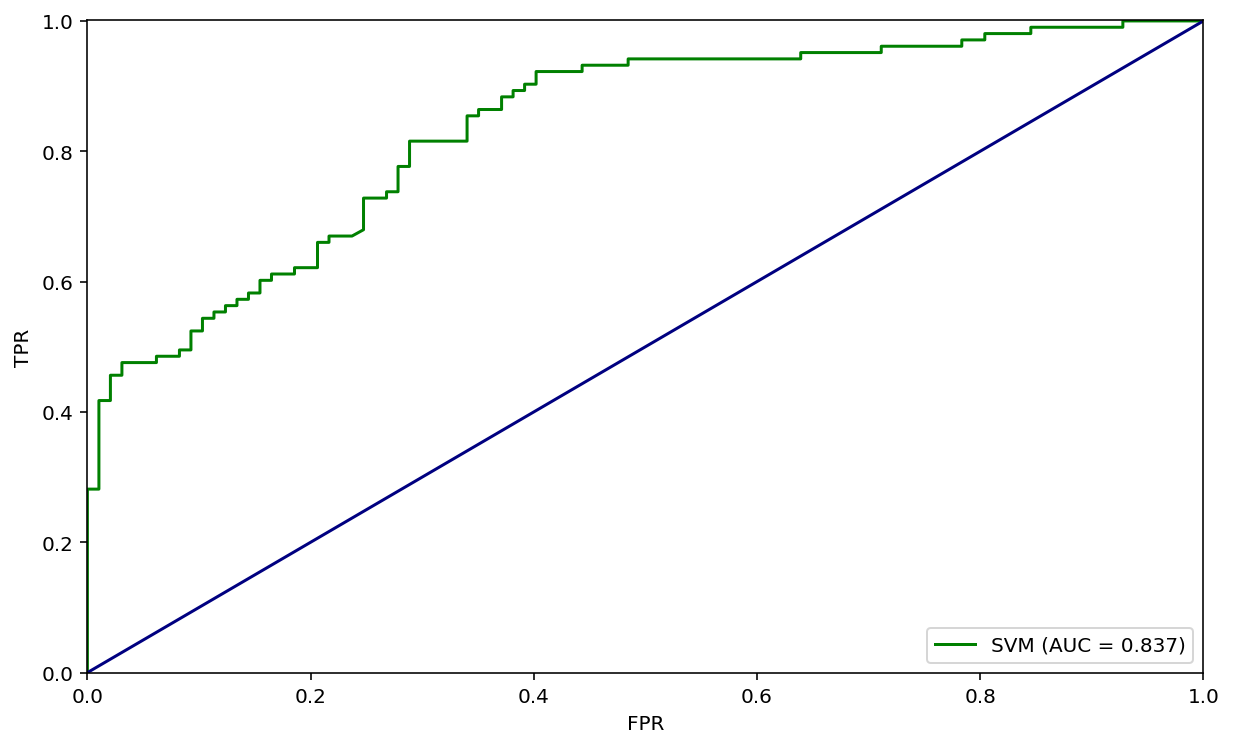

In [21]:
plot_roc(y_test, probas)

+ CAP

In [22]:
def plot_cap(y_true, probabilities):    
    base = pd.DataFrame(data=y_true, index=y_true.index)
    base.rename(columns={"Liked": "Real"}, inplace=True)
    base["Probability"] = probabilities[:,1]
    total = len(base[base.Real==1])
    
    perfect = (base.sort_values(by="Real", ascending=False)["Real"].cumsum()/total).values
    model = (base.sort_values(by="Probability", ascending=False)["Real"].cumsum()/total).values
    perfect = np.concatenate([[0], perfect])
    model = np.concatenate([[0], model])
    
    x = np.linspace(0, len(base), len(base)+1)/len(base)
    
    max_area = 0
    actual_area = 0
    h = x[1]-x[0]
    for i, (m, a) in enumerate(zip(perfect, model)):
        try:
            max_area+=((m-x[i])+(perfect[i-1]-(x[i-1])))*h/2
            actual_area+=((a-x[i])+(model[i-1]-(x[i-1])))*h/2
        except:
            continue
    accuracy_ratio = actual_area/max_area
    
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(x, model, color="green", label=f"SVM (AR = {accuracy_ratio:.3f})")
    plt.plot(x, perfect, color="red", label="Perfect Model")
    plt.plot([0,1], [0,1], color="navy")
    plt.xlabel("Reviews")
    plt.ylabel("Positive Reviews")
    plt.xlim((0,1))
    plt.ylim((0,1.01))
    plt.legend(loc=4)
    plt.show()
    
    return model, perfect, x

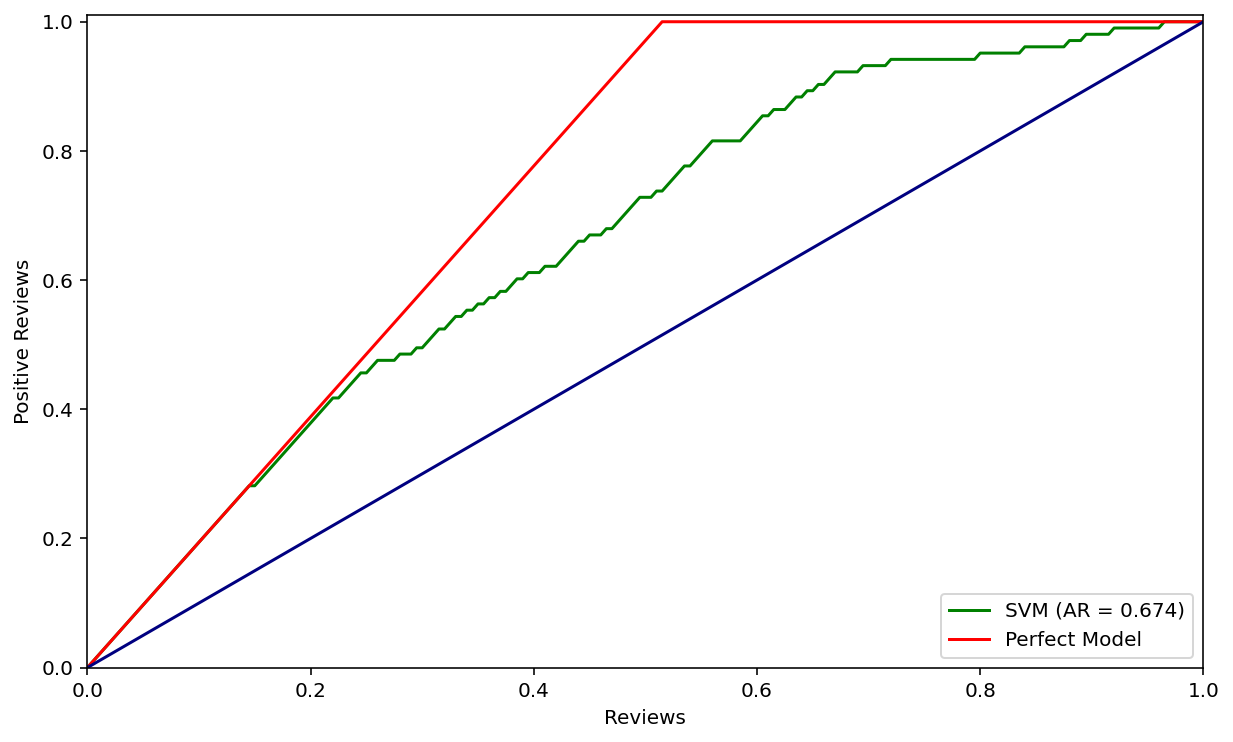

In [23]:
cap_model, cap_perfect, cap_x = plot_cap(y_test, probas)

In [24]:
cap_model[np.where(cap_x==0.5)][0]

0.7281553398058253

## NB

In [25]:
from sklearn.naive_bayes import GaussianNB

In [26]:
class SparseToArray(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, matrix, label=None):
        return self
    
    def transform(self, matrix):
        return matrix.toarray()

In [27]:
stemmer = PorterStemmer()

model = Pipeline(steps=[
    ("cleaning_texts", ReviewsCleaner(stemmer, stopwords)),
    ("bow", CountVectorizer(max_features=1500)),
    ("array", SparseToArray()),
    ("nb", GaussianNB())
])

In [28]:
model.fit(X_train, y_train)

/Users/gfluz94/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(memory=None,
         steps=[('cleaning_texts',
                 ReviewsCleaner(stemmer=None, stopwords=None)),
                ('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=1500, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('array', SparseToArray()),
                ('nb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [29]:
y_pred = model.predict(X_test)
probas = model.predict_proba(X_test)

+ Metrics

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.57      0.67        97
           1       0.68      0.87      0.77       103

    accuracy                           0.73       200
   macro avg       0.75      0.72      0.72       200
weighted avg       0.74      0.72      0.72       200



+ Confusion Matrix

In [31]:
confusion_matrix(y_test, y_pred)

Predicted,Negative,Positive
Real,,
Negative,55,42
Positive,13,90


+ ROC Curve and AUC

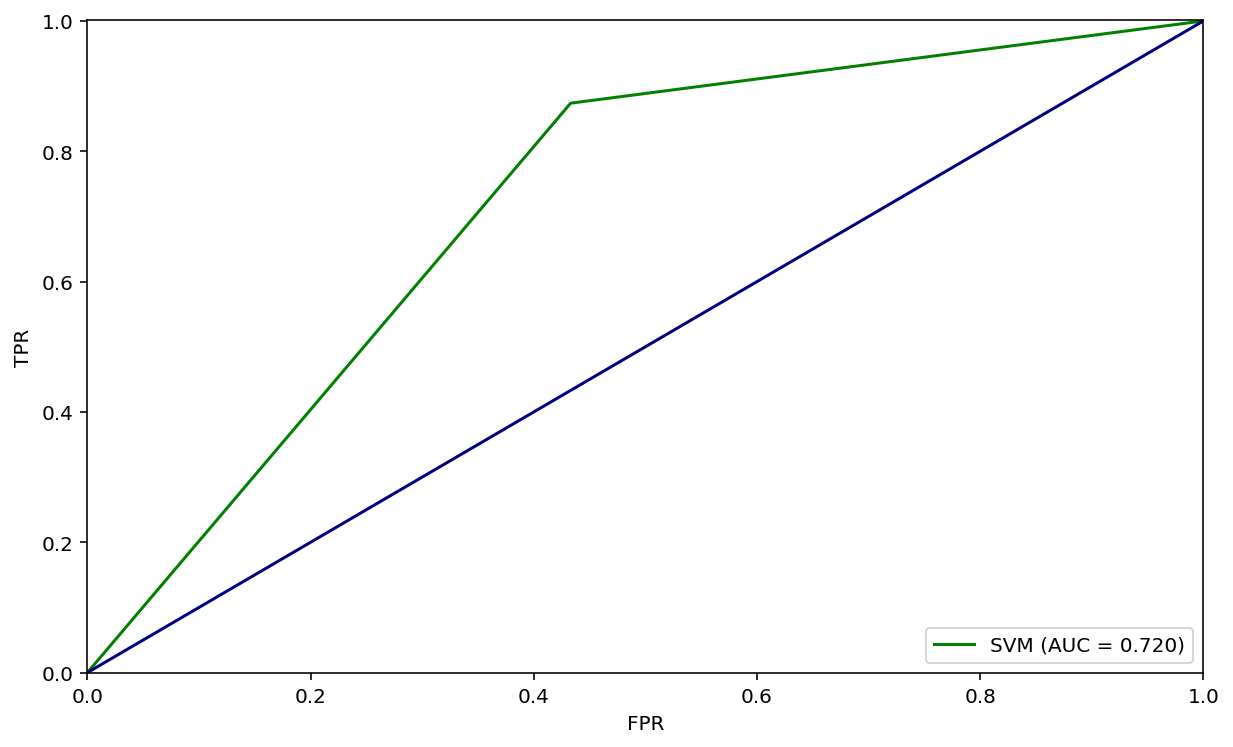

In [32]:
plot_roc(y_test, probas)

+ CAP

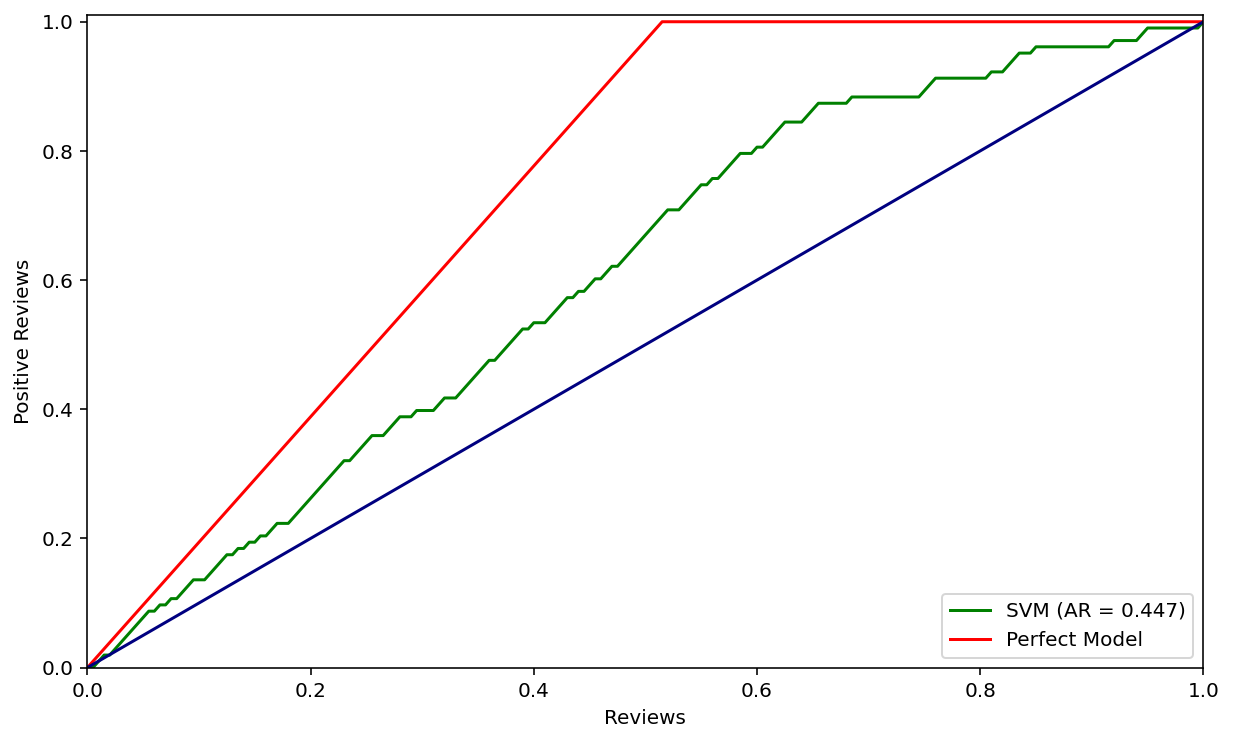

In [33]:
cap_model, cap_perfect, cap_x = plot_cap(y_test, probas)

In [34]:
cap_model[np.where(cap_x==0.5)][0]

0.6699029126213593

## SVM with TFIDF

In [35]:
stemmer = PorterStemmer()

model = Pipeline(steps=[
    ("cleaning_texts", ReviewsCleaner(stemmer, stopwords)),
    ("tfidf", TfidfVectorizer(max_df=0.8)),
    ("svm", SVC(C=1.0, kernel="linear", probability=True))
])

In [36]:
model.fit(X_train, y_train)

/Users/gfluz94/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(memory=None,
         steps=[('cleaning_texts',
                 ReviewsCleaner(stemmer=None, stopwords=None)),
                ('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_w...e,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weigh

In [37]:
y_pred = model.predict(X_test)
probas = model.predict_proba(X_test)

+ Metrics

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75        97
           1       0.79      0.68      0.73       103

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200



+ Confusion Matrix

In [39]:
confusion_matrix(y_test, y_pred)

Predicted,Negative,Positive
Real,,
Negative,78,19
Positive,33,70


+ ROC Curve and AUC

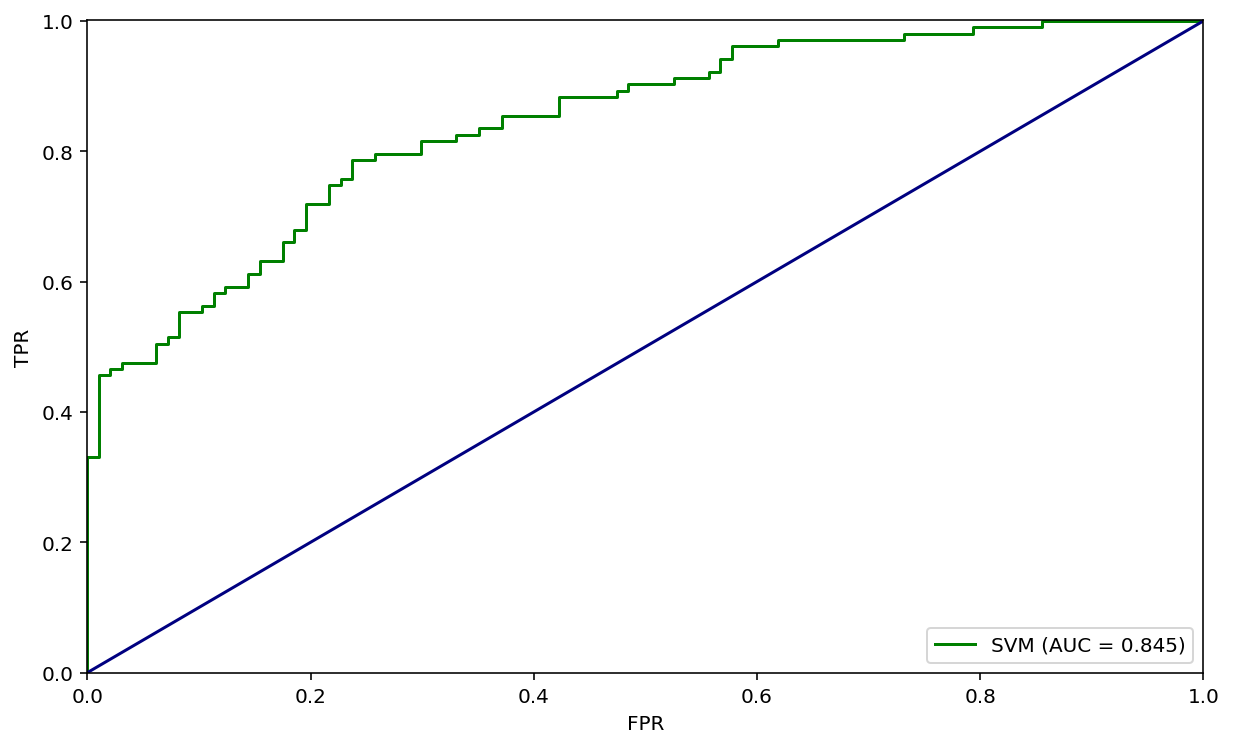

In [40]:
plot_roc(y_test, probas)

+ CAP

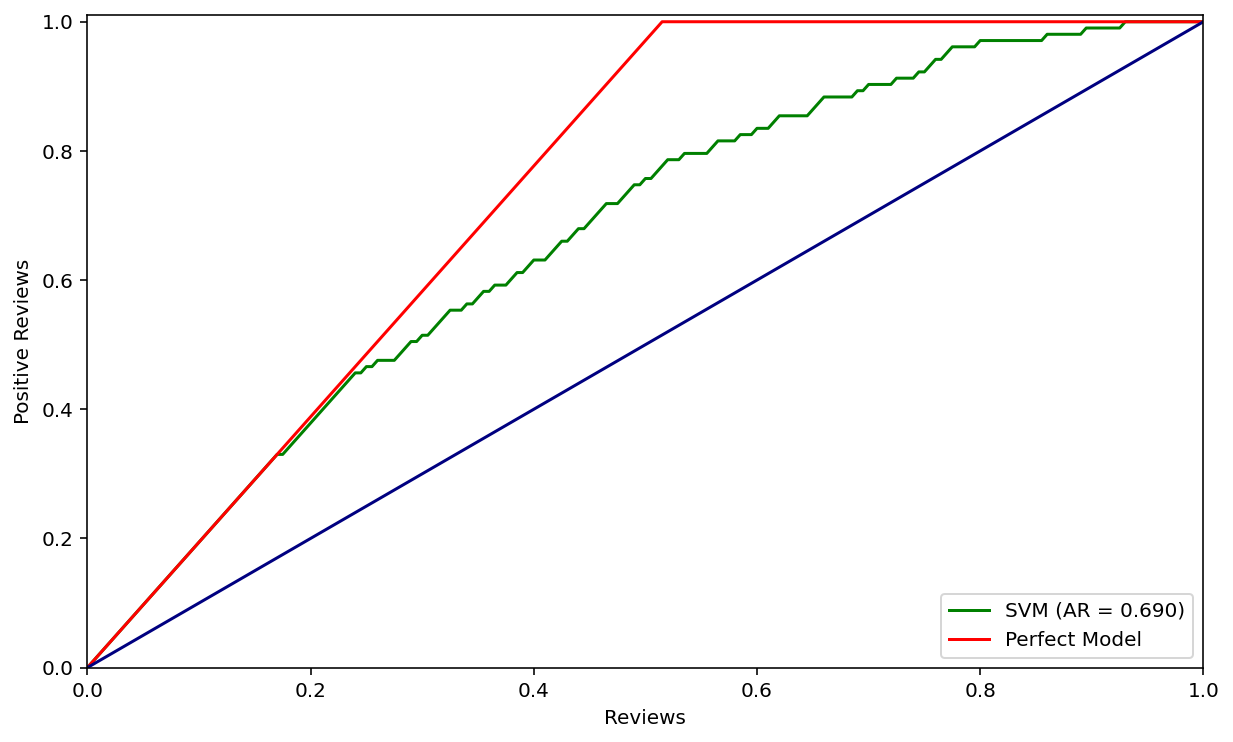

In [41]:
cap_model, cap_perfect, cap_x = plot_cap(y_test, probas)

In [42]:
cap_model[np.where(cap_x==0.5)][0]

0.7572815533980582

## SVM with TFIDF and w/o cleaning

In [43]:
model = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(max_df=0.8, stop_words="english", ngram_range=[1,2])),
    ("svm", SVC(C=1.0, kernel="linear", probability=True))
])

In [44]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=1, ngram_range=[1, 2], norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr'

In [45]:
y_pred = model.predict(X_test)
probas = model.predict_proba(X_test)

+ Metrics

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76        97
           1       0.78      0.75      0.76       103

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200



+ Confusion Matrix

In [47]:
confusion_matrix(y_test, y_pred)

Predicted,Negative,Positive
Real,,
Negative,75,22
Positive,26,77


+ ROC Curve and AUC

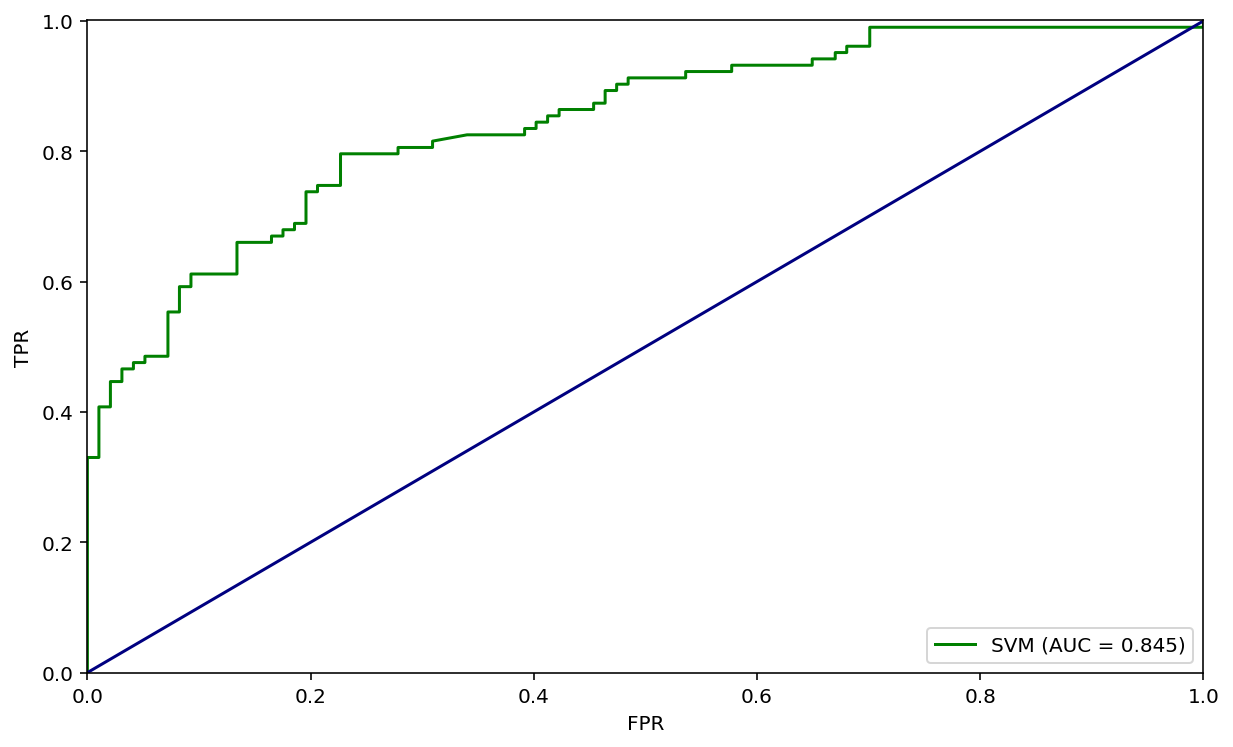

In [48]:
plot_roc(y_test, probas)

+ CAP

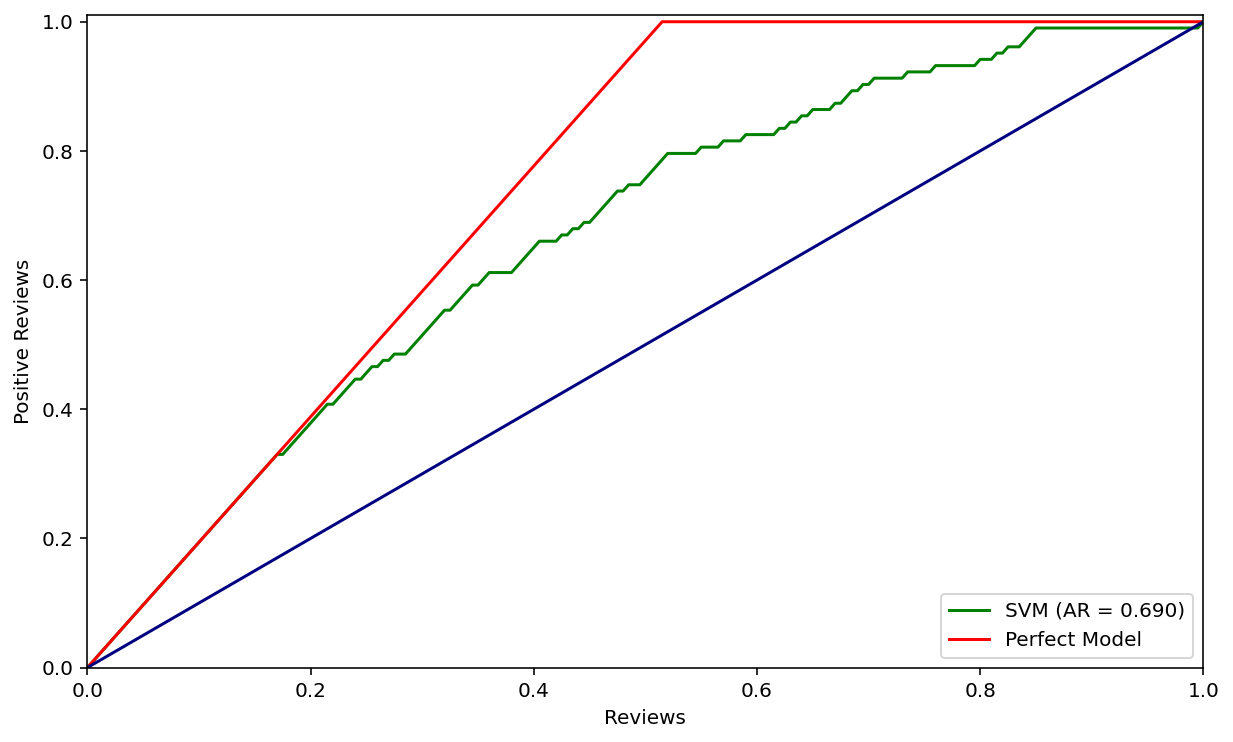

In [49]:
cap_model, cap_perfect, cap_x = plot_cap(y_test, probas)

In [50]:
cap_model[np.where(cap_x==0.5)][0]

0.7572815533980582